In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Dense, Dropout, Flatten, Embedding,Reshape,TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from keras.utils import to_categorical
from keras import layers
import warnings

warnings.filterwarnings('ignore')

In [14]:
df=pd.read_csv('/kaggle/input/final-ocr-dataset/f_labels.csv')
label=df['Label']

In [6]:
images = []

for i in range(84986):
    img_dir = f'/kaggle/input/final-ocr-dataset/FinalData/FinalData/{i}.png'
    
    try:
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        if image is None:
            print(f"Error reading image {i}.png. Skipping...")
            continue

        resized_image = cv2.resize(image, (10, 20))
        _, binary_image = cv2.threshold(resized_image, 128, 255, cv2.THRESH_BINARY)
        images.append(binary_image)
    except Exception as e:
        print(f"Error processing image {i}.png:", str(e))

Error reading image 40382.png. Skipping...


[ WARN:0@399.874] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/final-ocr-dataset/FinalData/FinalData/40382.png'): can't open/read file: check file path/integrity


Error reading image 56750.png. Skipping...
Error reading image 56751.png. Skipping...


[ WARN:0@466.858] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/final-ocr-dataset/FinalData/FinalData/56750.png'): can't open/read file: check file path/integrity
[ WARN:0@466.859] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/final-ocr-dataset/FinalData/FinalData/56751.png'): can't open/read file: check file path/integrity


In [7]:
len(images)

84983

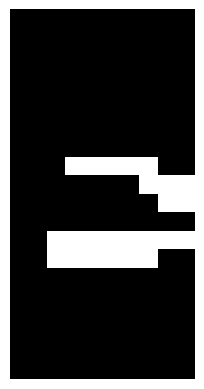

د


In [8]:
plt.imshow(cv2.cvtColor(images[2542], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
print(label[2542])

<Axes: xlabel='Label'>

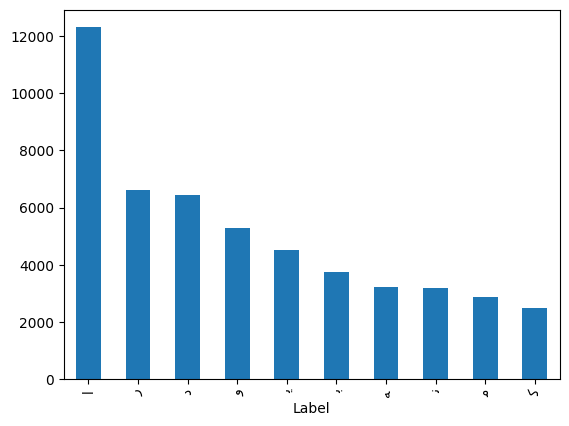

In [9]:
df['Label'].value_counts().head(10).plot(kind='bar')

<Axes: xlabel='Label'>

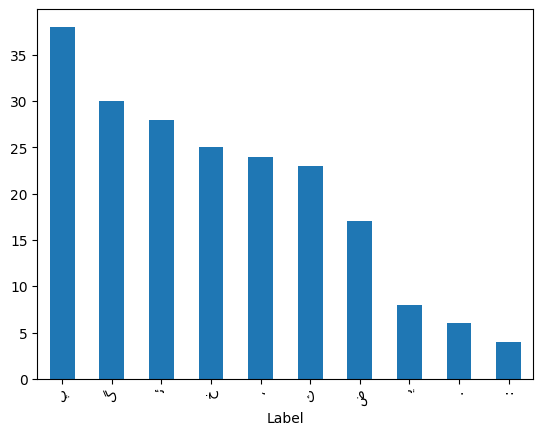

In [10]:
df['Label'].value_counts().tail(10).plot(kind='bar')

In [11]:
unique_labels = list(set(label))

label_to_number = {label: number for number, label in enumerate(unique_labels)}

label_numbers = [label_to_number[label] for label in label]

for label, number in label_to_number.items():
    print(f"{label}: {number}")


ﺛ: 0
ﻣ: 1
ﺑ: 2
ل: 3
ﮐ: 4
ﺷ: 5
ح: 6
ژ: 7
د: 8
2: 9
و: 10
ت: 11
ک: 12
9: 13
ن: 14
م: 15
ف: 16
ط: 17
6: 18
ﻻ: 19
ﭘ: 20
ﻧ: 21
ﻏ: 22
،: 23
ض: 24
ﻳ: 25
ج: 26
ﻫ: 27
پ: 28
ﻟ: 29
ﻋ: 30
ز: 31
ب: 32
ﺻ: 33
ق: 34
1: 35
3: 36
ث: 37
0: 38
ﻓ: 39
آ: 40
ﺗ: 41
ﭼ: 42
ه: 43
ﺧ: 44
ی: 45
5: 46
ﻪ: 47
ﻌ: 48
ذ: 49
ﺿ: 50
ﺣ: 51
چ: 52
ا: 53
8: 54
4: 55
ﺋ: 56
ﺳ: 57
ظ: 58
غ: 59
ﮔ: 60
ﻬ: 61
ص: 62
.: 63
ﯾ: 64
خ: 65
ﺟ: 66
گ: 67
ش: 68
س: 69
:: 70
ﻐ: 71
ر: 72
ع: 73
ﻗ: 74


In [12]:
len(label_numbers)

84983

In [ ]:
# label_map = {
#     '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
#     'ﺎ': 10, 'ﺐ': 11, 'ﺑ': 12, 'ﺖ': 13, 'ﺗ': 14, 'ﺚ': 15, 'ﺛ': 16, 'ﺞ': 17, 'ﺟ': 18,
#     'ﺢ': 19, 'ﺣ': 20, 'ﺦ': 21, 'ﺧ': 22, 'ﺪ': 23, 'ﺬ': 24, 'ﺮ': 25, 'ﺰ': 26, 'ﺲ': 27,
#     'ﺳ': 28, 'ﺶ': 29, 'ﺷ': 30, 'ﺺ': 31, 'ﺻ': 32, 'ﺾ': 33, 'ﺿ': 34, 'ﻂ': 35,
#     'ﻆ': 36, 'ﻉ': 37, 'ﻊ': 38, 'ﻋ': 39, 'ﻌ': 40, 'ﻍ': 41, 'ﻎ': 42, 'ﻏ': 43, 'ﻐ': 44,
#     'ﻒ': 45, 'ﻓ': 46, 'ﻖ': 47, 'ﻗ': 48, 'ﻘ': 49, 'ﻚ': 50, 'ﻛ': 51, 'ﻞ': 52,
#     'ﻟ': 53, 'ﻠ': 54, 'ﻢ': 55, 'ﻣ': 56, 'ﻦ': 57, 'ﻧ': 58, 'ﻩ': 59, 'ﻪ': 60, 'ﻫ': 61,
#     'ﻬ': 62, 'ﻮ': 63, 'ﯼ': 64, 'ﯾ': 65, 'ﭗ': 66, 'ﭘ': 67, 'ﭻ': 68, 'ﭼ': 69, 'ﮋ': 70,
#     'ﮓ': 71, 'ﮔ': 72, 'ﺋ': 73, 'ﺁ': 74, '،': 75, '؛': 76
# }

# numeric_labels = np.array([label_map[label] for label in label])

In [15]:
print(label[1523])
print(label_numbers[1523])

د
8


In [16]:
one_hot_labels = to_categorical(label_numbers)
print("Shape of One-Hot Encoded Labels:", one_hot_labels.shape)

Shape of One-Hot Encoded Labels: (84983, 75)


In [17]:
from sklearn.utils import shuffle

imgs, OHL = shuffle(images, one_hot_labels, random_state=42)

4


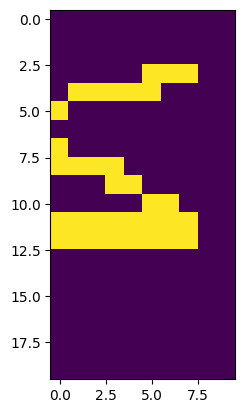

In [18]:
plt.imshow(imgs[1516])
print(np.argmax(OHL[1516]))


In [19]:
imgs2=imgs.copy()

In [20]:
imgs=np.expand_dims(imgs,axis=-1)
imgs = np.array(imgs)
imgs = imgs / 255.0

In [28]:
del images
del imgs

In [21]:
X_train, X_test, y_train, y_test = train_test_split(imgs, OHL, test_size=0.2, random_state=42,shuffle=False)

In [22]:
from tensorflow import keras
NN = keras.Sequential()
NN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20,10,1)))
NN.add(layers.MaxPooling2D((2, 2)))
NN.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
NN.add(layers.MaxPooling2D((2, 2)))
NN.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
NN.add(layers.MaxPooling2D((2, 2)))
NN.add(Flatten())
NN.add(Dense(64,activation='relu'))
NN.add(Dense(128,activation='relu'))
NN.add(Dense(len(label.unique()),activation='softmax'))

In [23]:
NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 8, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 2, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 1, 128)         0

In [24]:
X_train[0].shape

(20, 10, 1)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = NN.fit(X_train, y_train, epochs=15, batch_size=32,
                         validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/15
2125/2125 [==============================] - 13s 5ms/step - loss: 1.0144 - accuracy: 0.7876 - val_loss: 0.6484 - val_accuracy: 0.8845
Epoch 2/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.5907 - accuracy: 0.8937 - val_loss: 0.5739 - val_accuracy: 0.9005
Epoch 3/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.5271 - accuracy: 0.9065 - val_loss: 0.5336 - val_accuracy: 0.9084
Epoch 4/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.4924 - accuracy: 0.9138 - val_loss: 0.5190 - val_accuracy: 0.9151
Epoch 5/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.4653 - accuracy: 0.9181 - val_loss: 0.5083 - val_accuracy: 0.9163
Epoch 6/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.4464 - accuracy: 0.9212 - val_loss: 0.5034 - val_accuracy: 0.9185
Epoch 7/15
2125/2125 [==============================] - 9s 4ms/step - loss: 0.4287 - accuracy: 0.9234 - val_loss: 0.5157 - val_accuracy

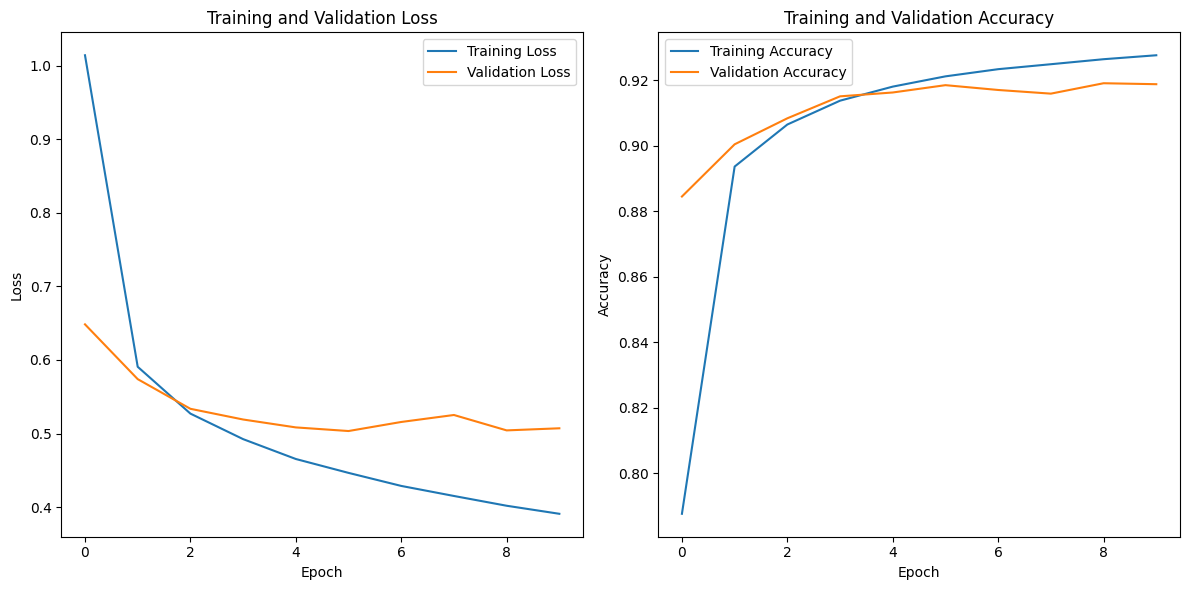

In [26]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

****Test The Model****

In [27]:
predictions=NN.predict(X_test,32)

532/532 [==============================] - 1s 2ms/step


In [28]:
print(np.argmax(predictions[48]))
print(np.argmax(y_test[48]))

31
31


In [29]:
print(np.argmax(predictions[12]))
print(np.argmax(y_test[12]))

27
27


In [30]:
NN.evaluate(X_test,y_test)

532/532 [==============================] - 1s 2ms/step - loss: 0.5034 - accuracy: 0.9185


[0.5033654570579529, 0.9185150265693665]

In [32]:
NN.save('ocr.h5')


In [ ]:
from IPython.display import FileLink
FileLink(r'ocr-NN-V2.h5')